# Load data
<https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)>

In [1]:
import pandas as pd
from data.utils import split_data

In [2]:
# Feature names
columns = [
    'Checking Status', 'Duration', 'Credit History', 'Purpose',
    'Credit Amount', 'Savings Account/Bonds', 'Employment Since',
    'Installment Rate', 'Personal Status', 'Debtors/Guarantors',
    'Residence Duration', 'Property Type', 'Age',
    'Other Installment Plans', 'Housing Ownership',
    'Number Existing Credits', 'Job', 'Number Liable', 'Telephone',
    'Foreign Worker', 'Good Customer'
]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]

# Load data.
df = pd.read_table('data/german.data', sep=' ', header=None,
                   index_col=None, names=columns)

# Make categorical columns numerical.
for column in categorical_columns:
    df[column] = pd.Categorical(df[column]).codes

# Make labels 0/1.
df['Good Customer'] = df['Good Customer'] - 1

In [3]:
# Split data.
train, val, test = split_data(df.values, seed=123,
                              val_portion=0.1,
                              test_portion=0.1)
Y_train = train[:, -1]
Y_val = val[:, -1]
Y_test = test[:, -1]
train = train[:, :-1]
val = val[:, :-1]
test = test[:, :-1]

# Train model

In [4]:
import numpy as np
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
# Train model.
model = GradientBoostingClassifier(n_estimators=100)
model.fit(train, Y_train)

GradientBoostingClassifier()

In [6]:
# Base rate performance.
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
print('Base rate cross entropy = {:.3f}'.format(
    log_loss(Y_val, p[np.newaxis].repeat(len(val), 0))))

# Model performance.
print('Model cross entropy = {:.3f}'.format(
    log_loss(Y_val, model.predict_proba(val))))

Base rate cross entropy = 0.602
Model cross entropy = 0.514


# Calculate feature importance

In [7]:
import sage
import matplotlib.pyplot as plt

In [8]:
# Setup
f = lambda x: model.predict_proba(x)
imputer = sage.utils.MarginalImputer(train, 512)
sampler = sage.PermutationSampler(f, imputer, 'cross entropy')

# Calculate SAGE values
sage_values = sampler(xy=(test, Y_test),
                      batch_size=2 ** 10,
                      n_permutations=2 ** 12,
                      bar=True)

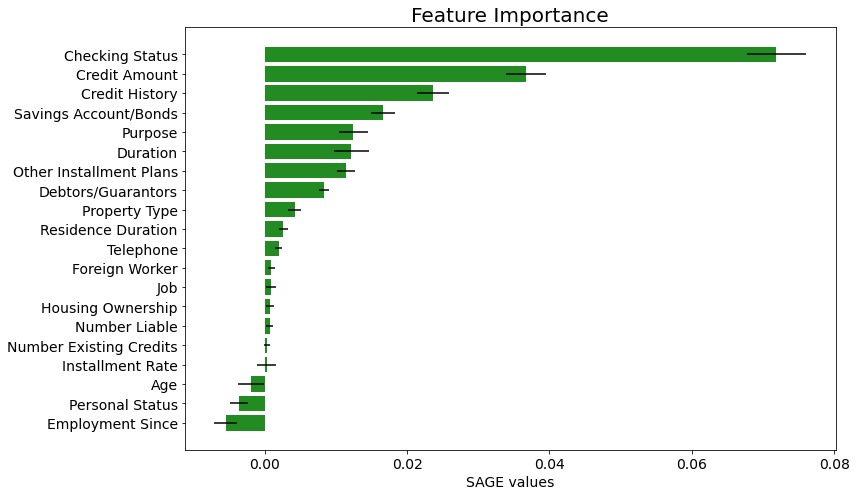

In [9]:
# Plot results
feature_names = columns[:-1]
sage_values.plot(feature_names)
plt.show()